In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Function to parse solverout.res file
def parse_solverout_res(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    flow_variables = []
    for line in lines:
        data = line.split()
        if len(data) == 6:
            flow_variables.append([float(value) for value in data[1:]])
    
    return np.array(flow_variables)

# Function to parse mesh.dat file for coordinates
def parse_mesh_coordinates(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    coordinates = []
    reading_coordinates = False
    
    for line in lines:
        if line.startswith('boundaries'):
            break
        
        if reading_coordinates:
            data = line.split()
            if len(data) == 3:
                element_number = int(data[0])
                x_coord = float(data[1])
                y_coord = float(data[2])
                coordinates.append([element_number, x_coord, y_coord])
        
        if line.startswith('coordinates'):
            reading_coordinates = True
    
    return np.array(coordinates)

# Function to load CFD data for a single case
def load_cfd_data(airfoil_folder, mach_folder, angle_folder):
    mesh_file = os.path.join(airfoil_folder, mach_folder, angle_folder, 'mesh.dat')
    solverout_file = os.path.join(airfoil_folder, mach_folder, angle_folder, 'solverout.res')
    
    coordinates = parse_mesh_coordinates(mesh_file)
    flow_variables = parse_solverout_res(solverout_file)
    
    return coordinates, flow_variables

# Function to extract ROI
def extract_roi(coordinates, flow_variables, x_range, y_range):
    mask = (coordinates[:, 1] >= x_range[0]) & (coordinates[:, 1] <= x_range[1]) & \
           (coordinates[:, 2] >= y_range[0]) & (coordinates[:, 2] <= y_range[1])
    filtered_coords = coordinates[mask][:, 1:]
    element_indices = np.where(mask)[0]
    filtered_variables = flow_variables[element_indices]
    return filtered_coords, filtered_variables

# Function to generate grid
def generate_grid(x_range, y_range, grid_size):
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    grid_x, grid_y = np.meshgrid(x, y)
    return grid_x, grid_y

# Function to interpolate flow variables onto grid
def interpolate_flow_variables(grid_x, grid_y, coords, variables):
    points = coords[:, :2]
    grid_z = np.ones((grid_x.shape[0], grid_x.shape[1], variables.shape[1]))
    for i in range(variables.shape[1]):
        grid_z[:, :, i] = griddata(points, variables[:, i], (grid_x, grid_y), method='cubic', fill_value=np.nan)
    return grid_z

# Function to apply global mean and standard deviation normalization
def normalize_flow_variables_global(grid_z, global_mean, global_std):
    for i in range(grid_z.shape[2]):  # Iterate over channels
        grid_z[:, :, i] = (grid_z[:, :, i] - global_mean[i]) / global_std[i]
    return grid_z

# Function to apply global min-max normalization
def normalize_flow_variables_global_minmax(grid_z, global_min, global_max):
    for i in range(grid_z.shape[2]):  # Iterate over channels
        grid_z[:, :, i] = (grid_z[:, :, i] - global_min[i]) / (global_max[i] - global_min[i])
    return grid_z

# Function to get scale values for plot
def get_min_max_per_channel(grid_z):
    num_channels = grid_z.shape[2]
    min_values = np.zeros(num_channels)
    max_values = np.zeros(num_channels)
    
    for i in range(num_channels):
        min_values[i] = np.nanmin(grid_z[:, :, i])
        max_values[i] = np.nanmax(grid_z[:, :, i])
    
    return min_values, max_values

# Function to plot flow variables
def plot_flow_variables(grid_x, grid_y, grid_z, title, min_values=None, max_values=None):
    num_channels = grid_z.shape[2]
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
    
    for i in range(num_channels):
        vmin = min_values[i] if min_values is not None else None
        vmax = max_values[i] if max_values is not None else None
        cs = axes[i].contourf(grid_x, grid_y, grid_z[:, :, i], levels=200, cmap='turbo', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'{title} - Channel {i + 1}')
        fig.colorbar(cs, ax=axes[i], orientation='vertical')
    
    plt.tight_layout()
    plt.show()

# Function to plot inferred variables
def plot_inferred_variables(grid_x, grid_y, grid_z, title, min_values=None, max_values=None):
    num_channels = grid_z.shape[2]
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
    
    for i in range(num_channels):
        vmin = min_values[i] if min_values is not None else None
        vmax = max_values[i] if max_values is not None else None
        cs = axes[i].contourf(grid_x, grid_y, grid_z[:, :, i], levels=200, cmap='turbo', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'{title} - Channel {i + 1}')
        fig.colorbar(cs, ax=axes[i], orientation='vertical')
    
    plt.tight_layout()
    plt.show()
    
# Function to plot original flow variables
def plot_original_flow_variables(coords, variables, title):
    fig, axes = plt.subplots(1, variables.shape[1], figsize=(20, 5))
    for i in range(variables.shape[1]):
        scatter = axes[i].scatter(coords[:, 0], coords[:, 1], c=variables[:, i], cmap='turbo')
        axes[i].set_title(f'{title} - Channel {i + 1}')
        fig.colorbar(scatter, ax=axes[i], orientation='vertical')
    plt.tight_layout()
    plt.show()

def calculate_error(normalized_z, inferred_z, epsilon=1e-10):
    abs_error = np.abs(inferred_z - normalized_z)
    rel_error = abs_error / (np.abs(normalized_z) + epsilon)
    pare = rel_error * 100.0
    return pare

def plot_error(grid_x, grid_y, error, title): #currently capped at 15%
    num_channels = error.shape[2]
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))

    for i in range(num_channels):
        # Cap error values at 100
        error_capped = np.minimum(error[:, :, i], 15)
        
        # Create a masked array where NaNs are masked
        #error_masked = np.ma.array(error_capped, mask=np.isnan(error_capped))
        
        # Create contour plot, ignoring NaN values
        cs = axes[i].contourf(grid_x, grid_y, error_capped, levels=np.linspace(0, 15, 21), cmap='Reds', extend='max')
        
        axes[i].set_title(f'Channel {i + 1}')
        fig.colorbar(cs, ax=axes[i], orientation='vertical')
    
    fig.suptitle(f'Percent Absolute Relative Error - {title}')
    plt.tight_layout()
    plt.show()


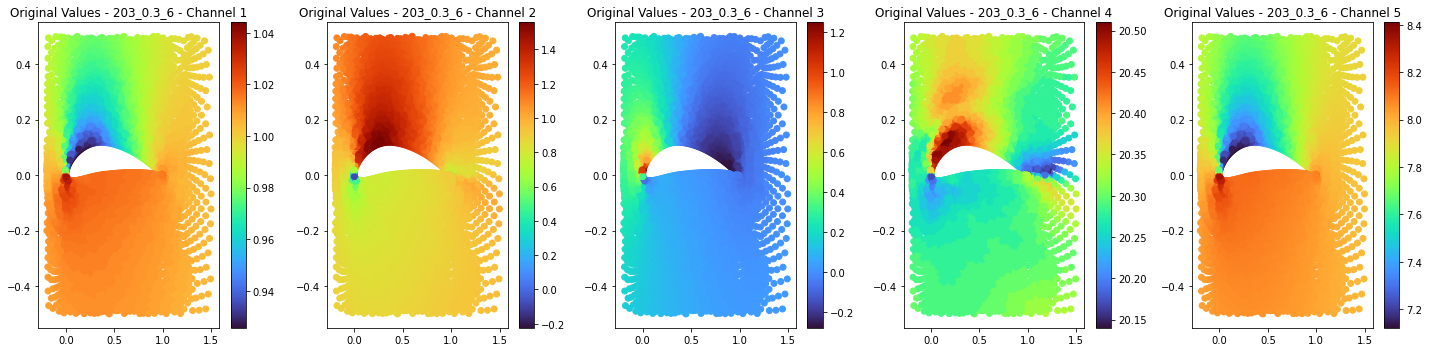

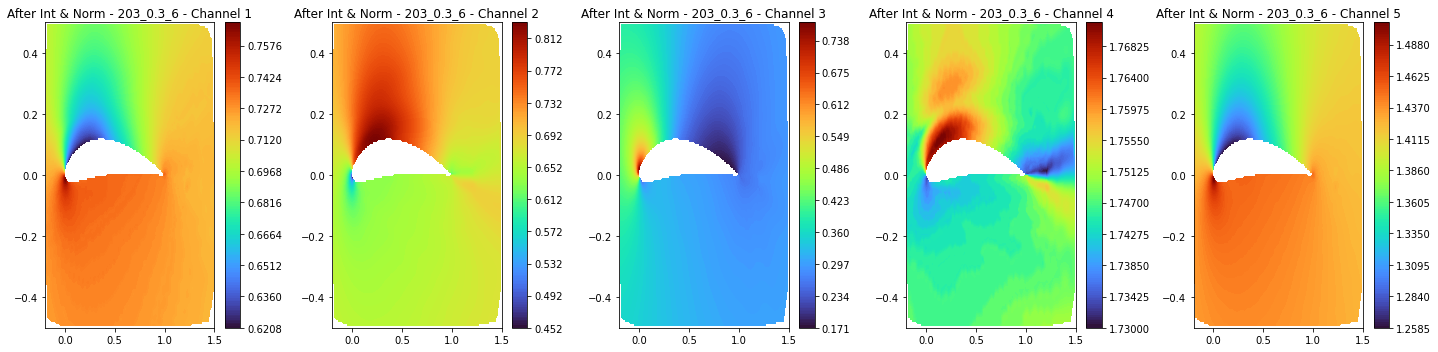

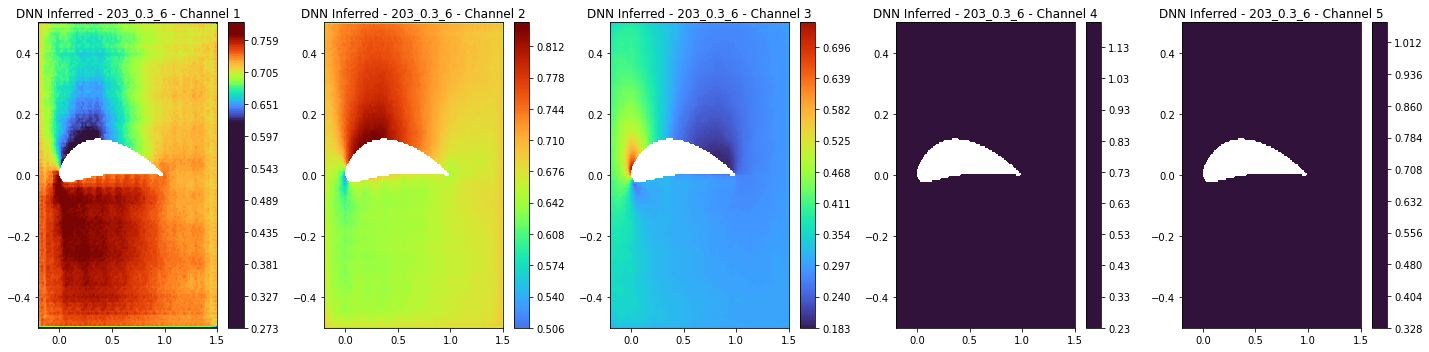

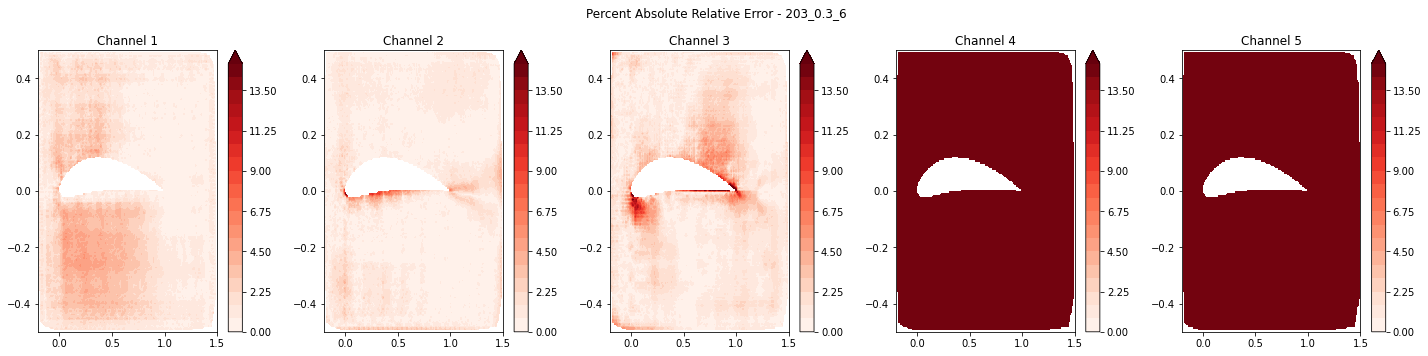

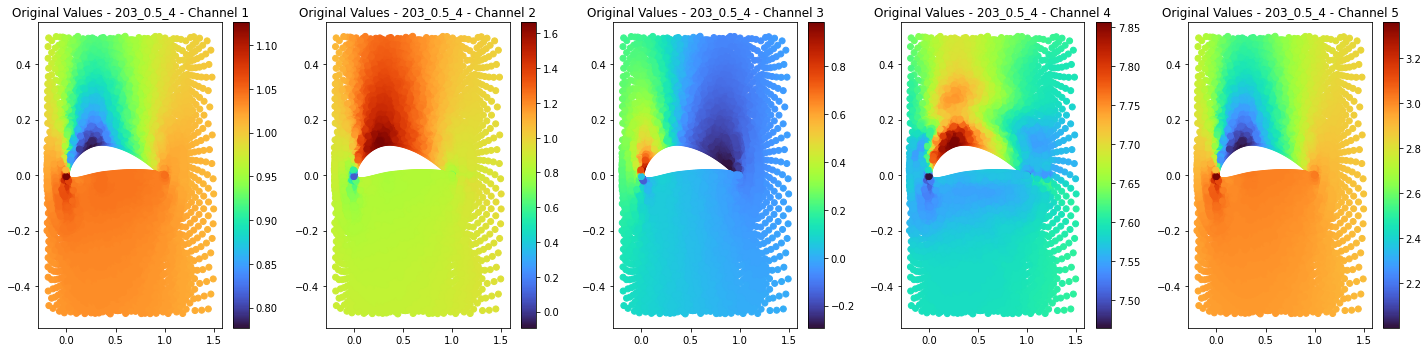

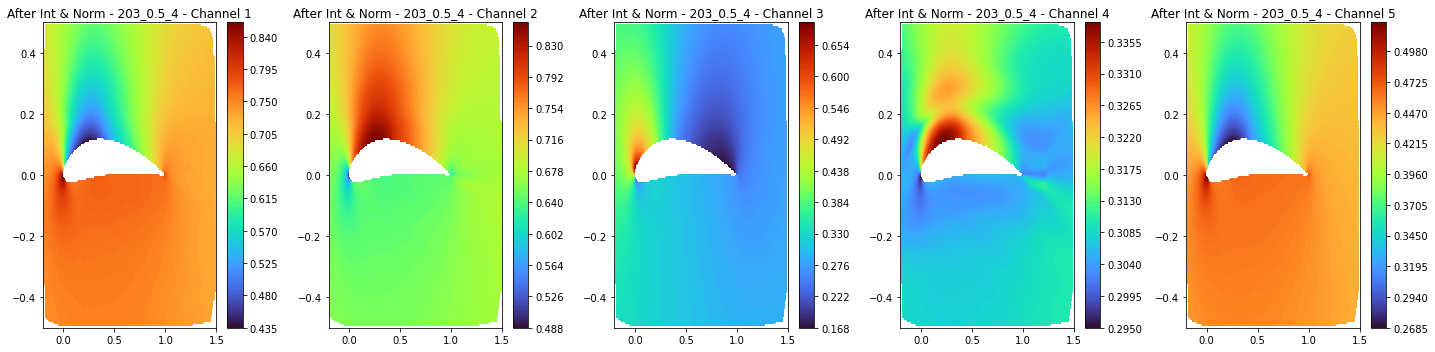

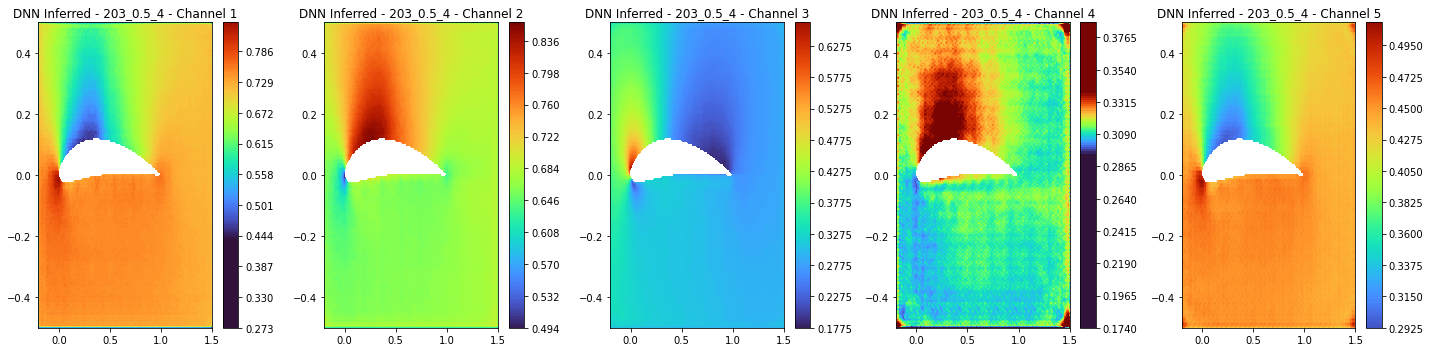

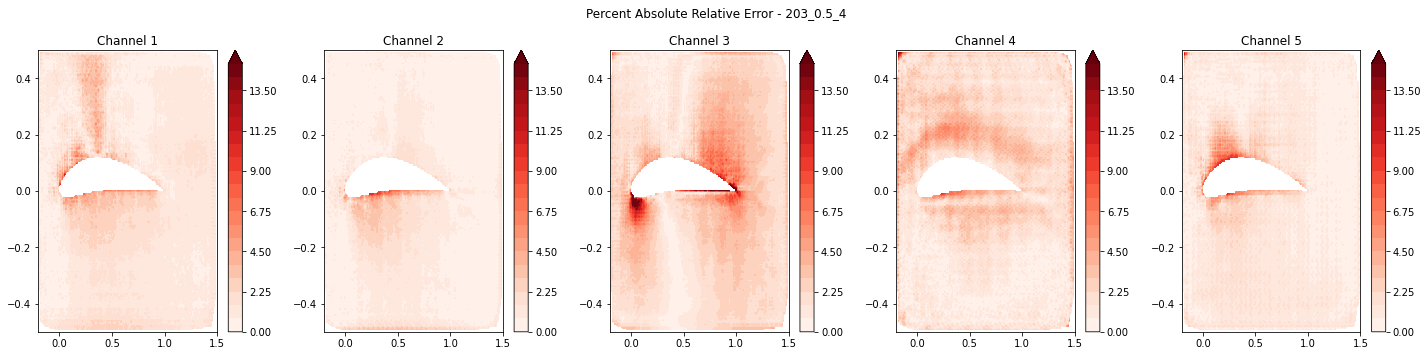

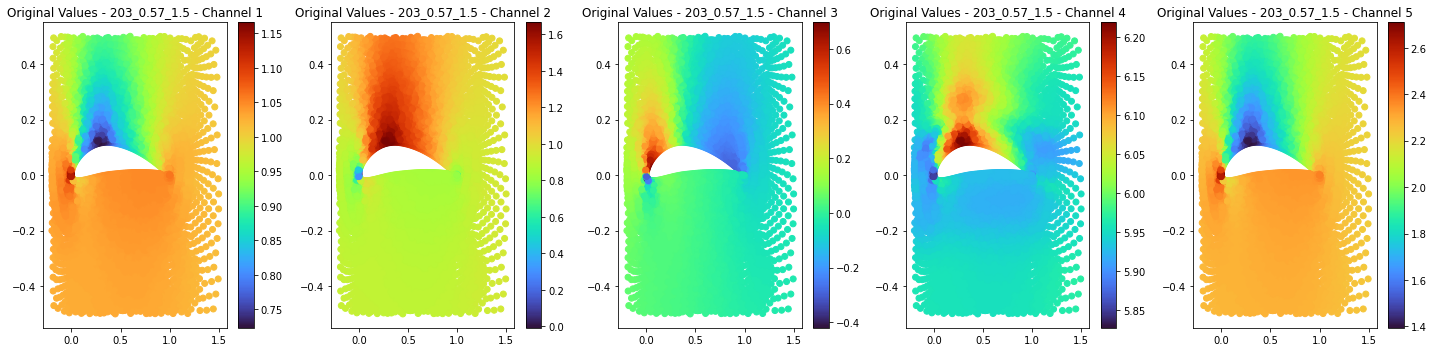

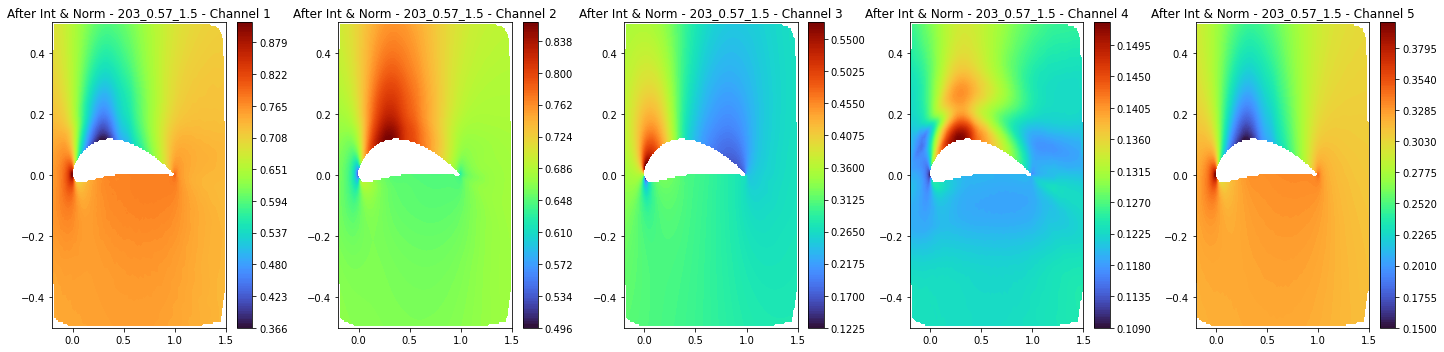

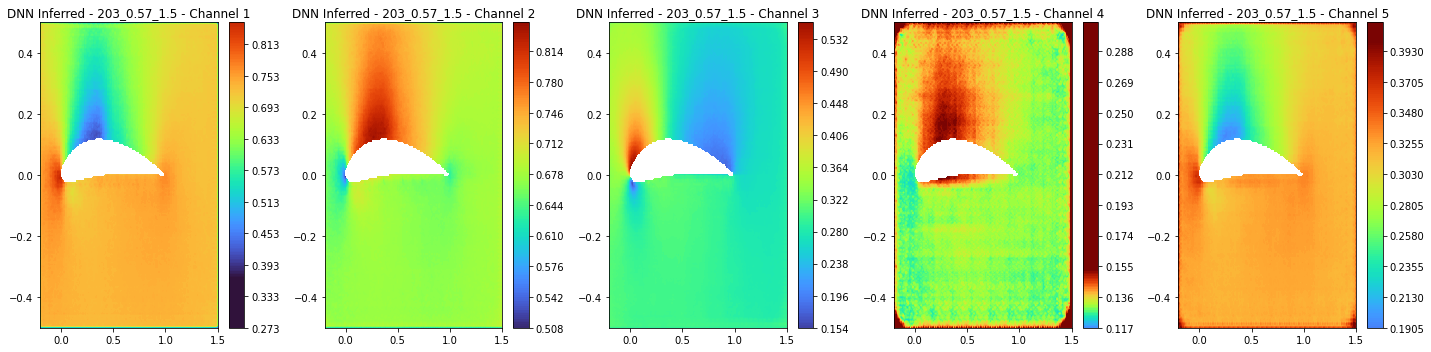

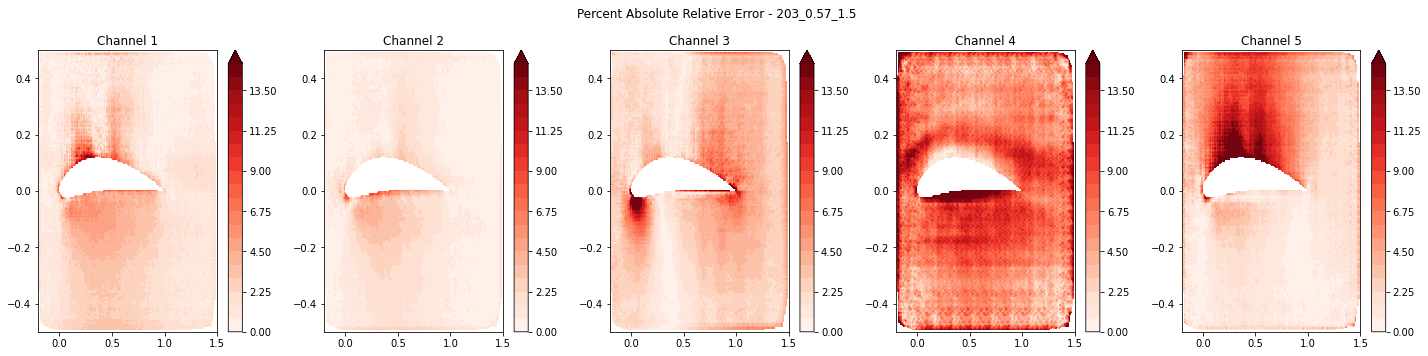

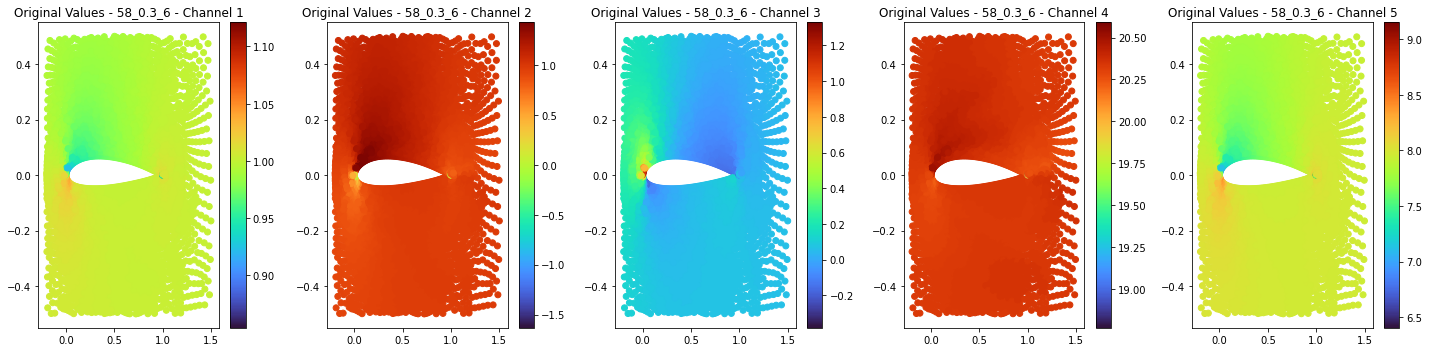

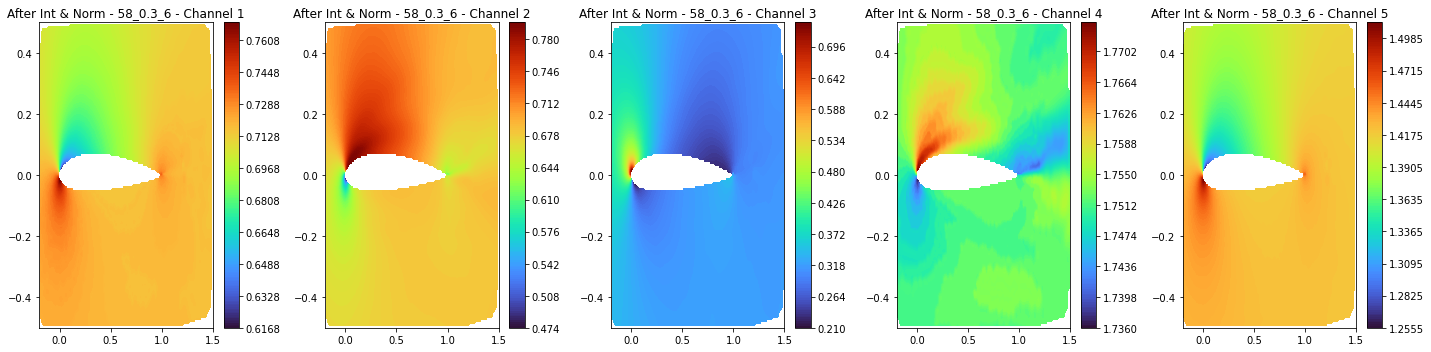

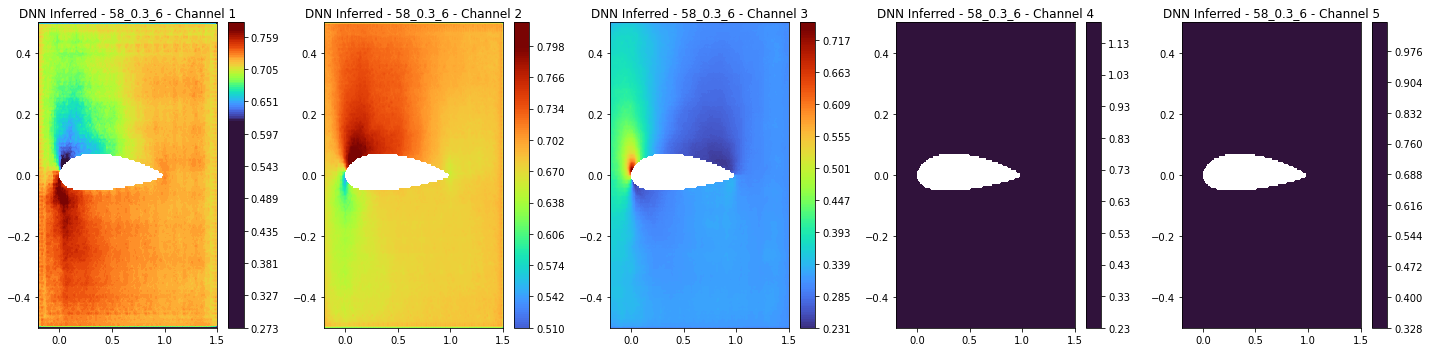

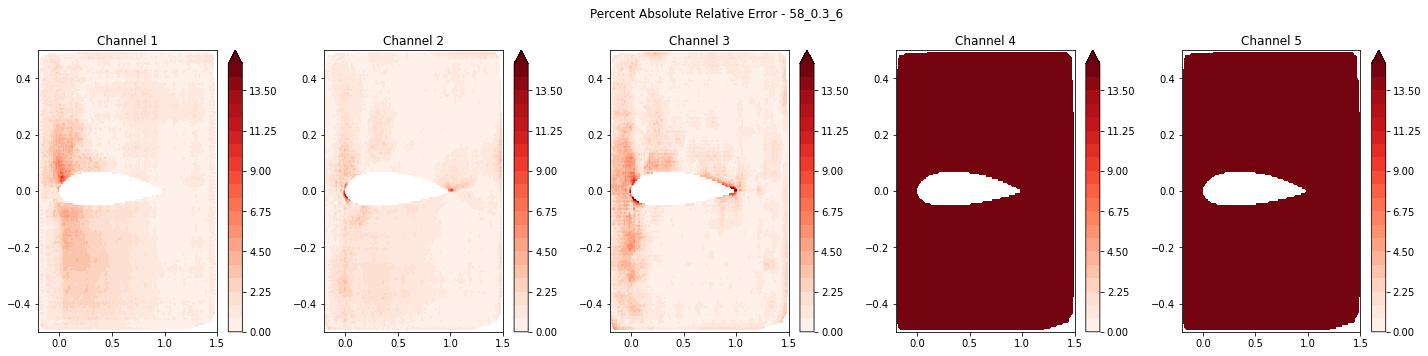

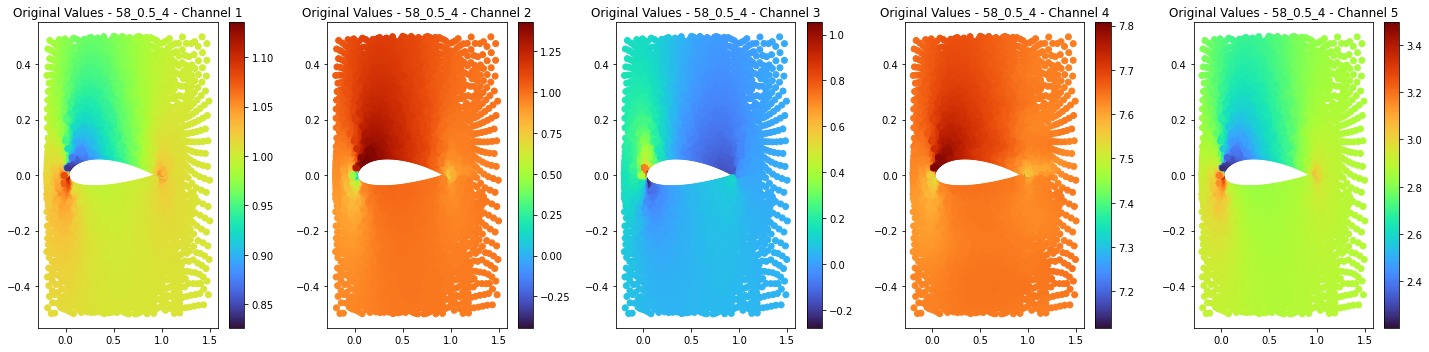

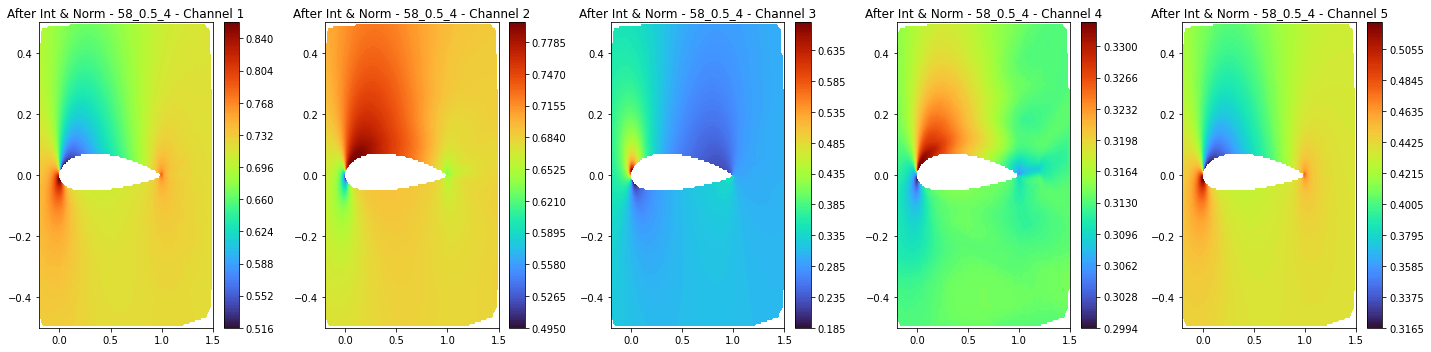

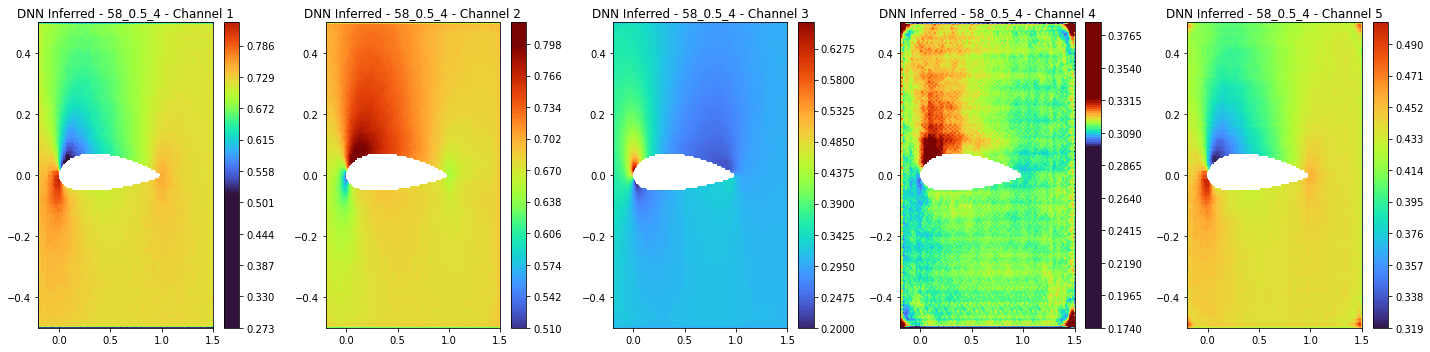

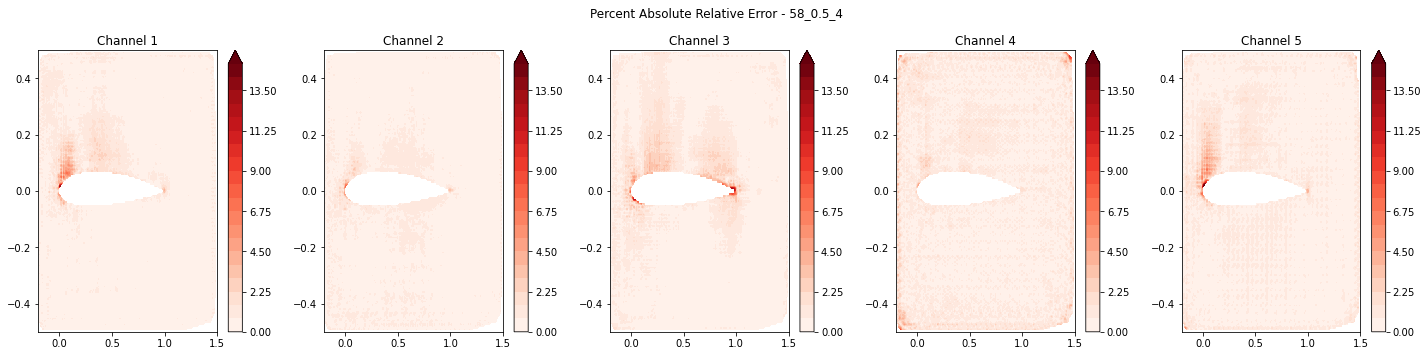

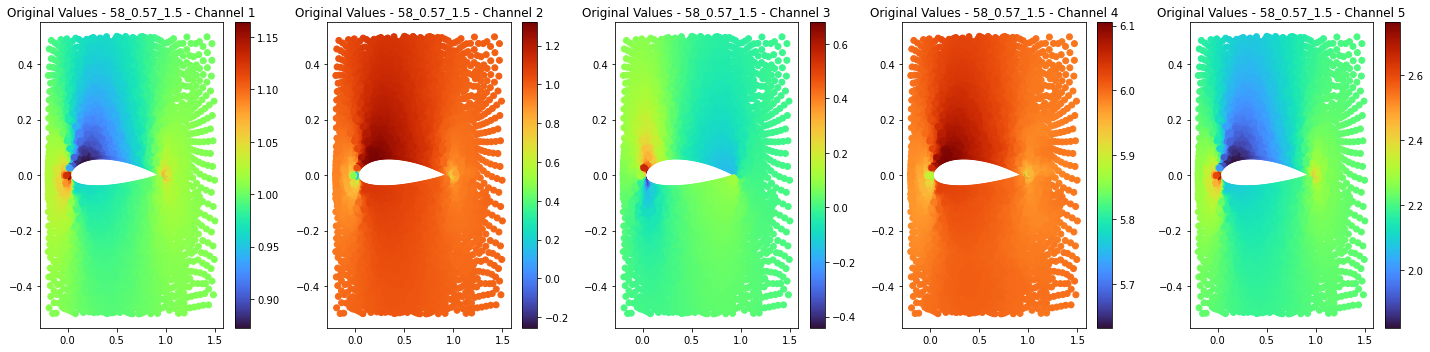

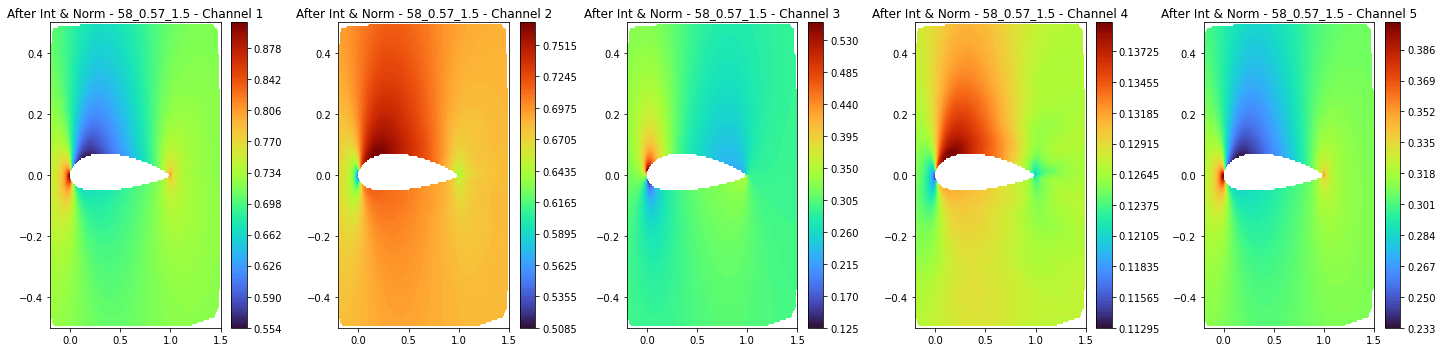

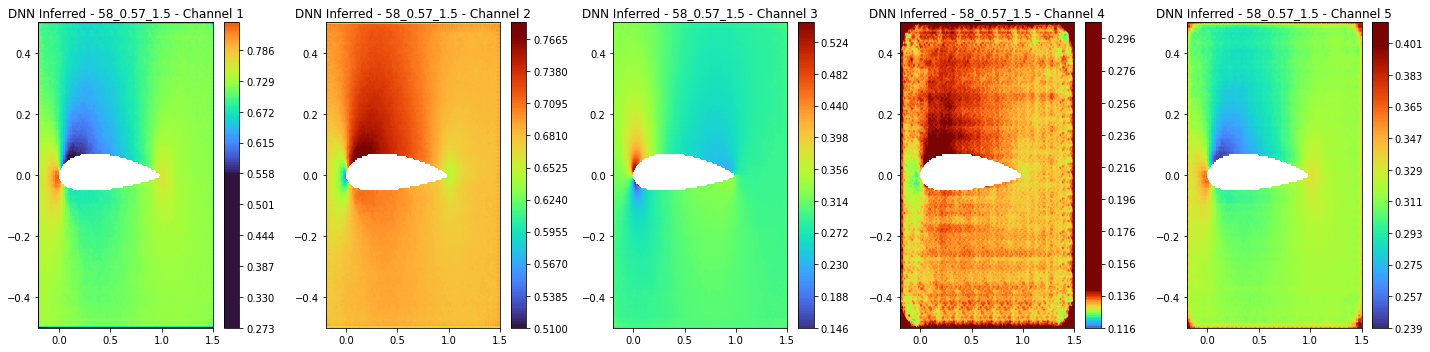

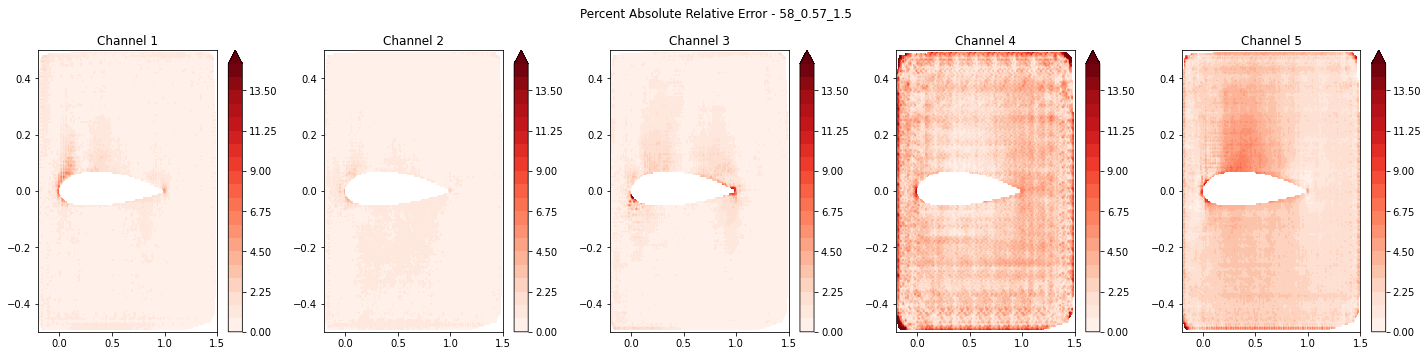

In [2]:
# Define region of interest
x_range = [-0.2, 1.5]
y_range = [-0.5, 0.5]
grid_size = 150

# Load global mean and standard deviation
#global_mean = np.load('E:/SU/Dis/CFD/global_mean.npy')
#global_std = np.load('E:/SU/Dis/CFD/global_std.npy')

# Load global min and max values
global_min = np.load('E:/SU/Dis/CFD/global_min.npy')
global_max = np.load('E:/SU/Dis/CFD/global_max.npy')

# Define base directory for raw data
base_dir = 'E:/SU/Dis/DNN/Visualiser/cfd_data' #similar folder structure to CFD/raw_data 
output_dir = 'E:/SU/Dis/DNN/Visualiser/cfd_roi_data'

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over each airfoil folder
airfoil_folders = os.listdir(base_dir)
for airfoil_folder in airfoil_folders:
    airfoil_path = os.path.join(base_dir, airfoil_folder)
    if not os.path.isdir(airfoil_path):
        continue
    
    mach_folders = os.listdir(airfoil_path)
    for mach_folder in mach_folders:
        mach_path = os.path.join(airfoil_path, mach_folder)
        if not os.path.isdir(mach_path):
            continue
        
        angle_folders = os.listdir(mach_path)
        for angle_folder in angle_folders:
            angle_path = os.path.join(mach_path, angle_folder)
            if not os.path.isdir(angle_path):
                continue
            
            # Load CFD data for this case
            coordinates, flow_variables = load_cfd_data(airfoil_path, mach_folder, angle_folder)
            
            # Extract ROI
            filtered_coords, filtered_variables = extract_roi(coordinates, flow_variables, x_range, y_range)
            
            # Generate grid
            grid_x, grid_y = generate_grid(x_range, y_range, grid_size)
            
            # Load SDF (previously generated and saved)
            sdf_file = os.path.join('E:/SU/Dis/DNN/Visualiser/sdf_data', f'{airfoil_folder}.npy')
            airfoil_contour = np.load(sdf_file)
            
            # Plot original flow variables
            plot_original_flow_variables(filtered_coords, filtered_variables, f'Original Values - {airfoil_folder}_{mach_folder}_{angle_folder}')
            
            # Interpolate flow variables
            interpolated_z = interpolate_flow_variables(grid_x, grid_y, filtered_coords, filtered_variables)
            
            # Set points inside the airfoil to NaN
            interpolated_z[airfoil_contour < 0] = np.nan
            
            # Normalize flow variables using global statistics
            normalized_z = normalize_flow_variables_global_minmax(interpolated_z, global_min, global_max)
            
            # Set points inside the airfoil to NaN again
            normalized_z[airfoil_contour < 0] = np.nan
            min_values, max_values = get_min_max_per_channel(normalized_z)
        
            # Plot flow variables after normalization
            plot_flow_variables(grid_x, grid_y, normalized_z, f'After Int & Norm - {airfoil_folder}_{mach_folder}_{angle_folder}', min_values, max_values)
            
            # load DNN inferred data
            inferred_file = os.path.join('E:/SU/Dis/DNN/Visualiser/inferred_data', f'{airfoil_folder}_{mach_folder}_{angle_folder}.npy')
            inferred_z = np.load(inferred_file)
            inferred_z[airfoil_contour < 0] = np.nan
            
            # Plot flow variables before normalization
            plot_inferred_variables(grid_x, grid_y, inferred_z, f'DNN Inferred - {airfoil_folder}_{mach_folder}_{angle_folder}', min_values, max_values)
           
            # Compute PARE
            error = calculate_error(normalized_z, inferred_z)

            # Plot error
            plot_error(grid_x, grid_y, error, f'{airfoil_folder}_{mach_folder}_{angle_folder}')

            # Save normalized flow variables
            output_file = os.path.join(output_dir, f'{airfoil_folder}_{mach_folder}_{angle_folder}.npy')
            np.save(output_file, normalized_z)